# General Exploratory Analysis of Suicide Phenomena

GOALS:
1. Identify main suicide trends across critical data features
2. Observe anomalies in indetified trends and try to explain them
3. Identify main correlations between critical data features

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

# for Box-Cox Transformation
from scipy import stats
from scipy.stats import pearsonr

# for min_max scaling
from mlxtend.preprocessing import minmax_scaling

import matplotlib.pyplot as plt
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

# for Welch t-test
import scipy.stats

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['world-capitals-gps', 'suicide-rates-overview-1985-to-2016']


# **Data Cleaning**: 

# 1.1 Missing data

In [2]:
df = pd.read_csv('../input/suicide-rates-overview-1985-to-2016/master.csv')

total_cells = np.product(df.shape)
missing_cells = df.isnull().sum().sum()

percent_missing_cells=(missing_cells/total_cells) * 100

# percent of data that is missing
print ('Total # of Cells: %d' %total_cells)
print('Total # of Missing Cells: %d' %missing_cells)
print('Percent Missing Cells: %d' %percent_missing_cells)

print('\nColumns with missing_values_count: ')
df.isnull().sum()

Total # of Cells: 333840
Total # of Missing Cells: 19456
Percent Missing Cells: 5

Columns with missing_values_count: 


country                   0
year                      0
sex                       0
age                       0
suicides_no               0
population                0
suicides/100k pop         0
country-year              0
HDI for year          19456
 gdp_for_year ($)         0
gdp_per_capita ($)        0
generation                0
dtype: int64

In [3]:
# Dropping HDI column based on Missing Value analysis
df.drop(columns=['HDI for year'],inplace=True)

# Converting GFD_per_capita to numeric
df['gdp_per_capita ($)']=pd.to_numeric(df['gdp_per_capita ($)'])

# Dropping 'years' from Age feature for easier read
df['age'].replace(regex=True,inplace=True,to_replace=r'years',value=r'')

# Removing word Generation from generation feature
df['generation']=df['generation'].apply(lambda x: x.replace('Generation',''))

# 1.2 Data quantity by country

Text(0.5, 1.0, 'Data count by Country \nFrom 1987 to 2016')

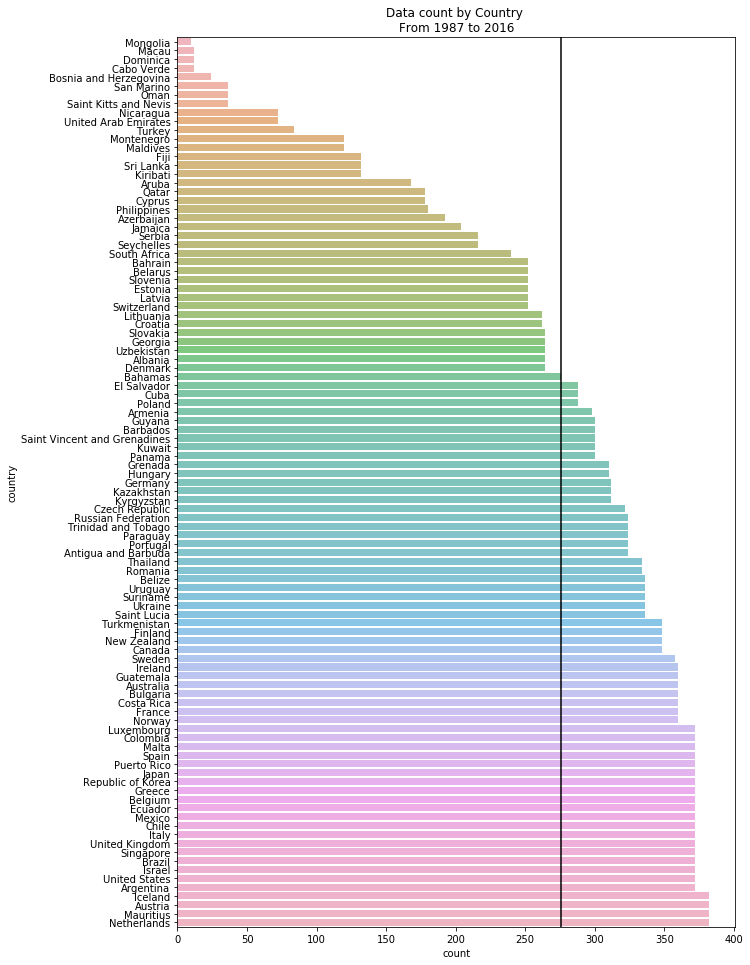

In [4]:

plt.figure(figsize=(22,36))
plt.subplot(221)
sns.countplot(y='country',data=df, alpha=0.7, order=reversed(df['country'].value_counts().index))
plt.axvline(x=df['country'].value_counts().mean(), color='k')
plt.gca().xaxis.tick_bottom()
plt.title('Data count by Country \nFrom 1987 to 2016')



* As we can see, some countries have a very low data count
* Lets look at data count box plot and density density distribution

Text(0.5, 1.0, 'Data count density distribution by Country')

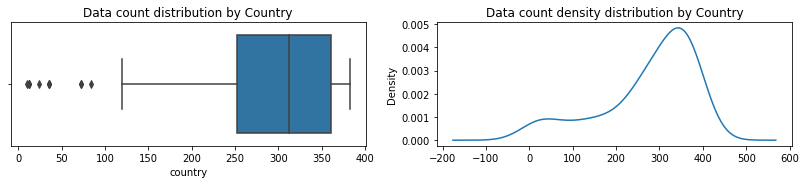

In [5]:
plt.figure(figsize=(14,5))
plt.subplot(221)
sns.boxplot(x=df['country'].value_counts())
plt.gca().xaxis.tick_bottom()
plt.title('Data count distribution by Country')

plt.subplot(222)
df['country'].value_counts().plot.kde()
plt.gca().xaxis.tick_bottom()
plt.title('Data count density distribution by Country')

* Indeed, boxplot shows several country outliers with data count below 120
* For the purpose of this analysis, countries with low data count will not be removed, since normalized suicides and GDP counts will be used primerely for the analysis

# 1.3 Data quantity by Age,Sex, and Generation

Text(0.5, 1.0, 'Data count by Sex')

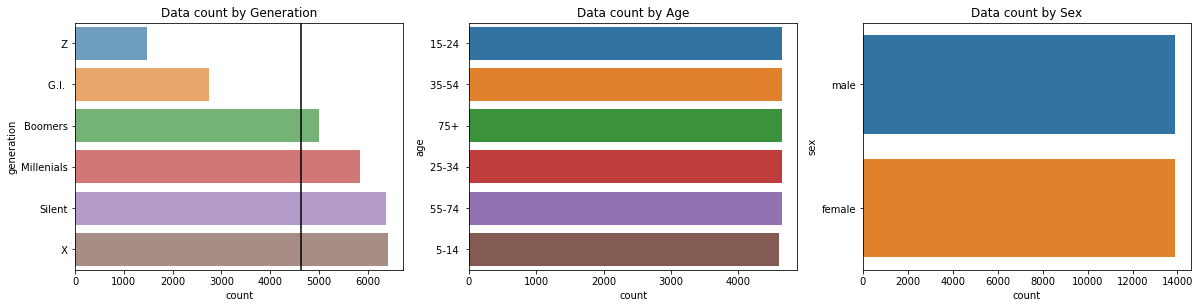

In [6]:
plt.figure(figsize=(20,10))
#fig.subplots_adjust(hspace=0.4, wspace=1)

plt.subplot(231)
sns.countplot(y='generation',data=df, alpha=0.7, order=reversed(df['generation'].value_counts().index))
plt.axvline(x=df['generation'].value_counts().mean(), color='k')
plt.gca().xaxis.tick_bottom()
plt.title('Data count by Generation')

plt.subplot(232)
sns.countplot(y='age',data=df)
plt.gca().xaxis.tick_bottom()
plt.title('Data count by Age')

plt.subplot(233)
sns.countplot(y='sex',data=df)
plt.gca().xaxis.tick_bottom()
plt.title('Data count by Sex')

* Data count by generation shows that generation G.I. and Z are below the mean count. This should be taking into the account during the analysis
* Data count within age groups is are equal, for the exception of 5-14 group, which is slightly lower
* Data count between sex groups is equal

# 2. EDA

# 2.1 Global suicide trend by Country

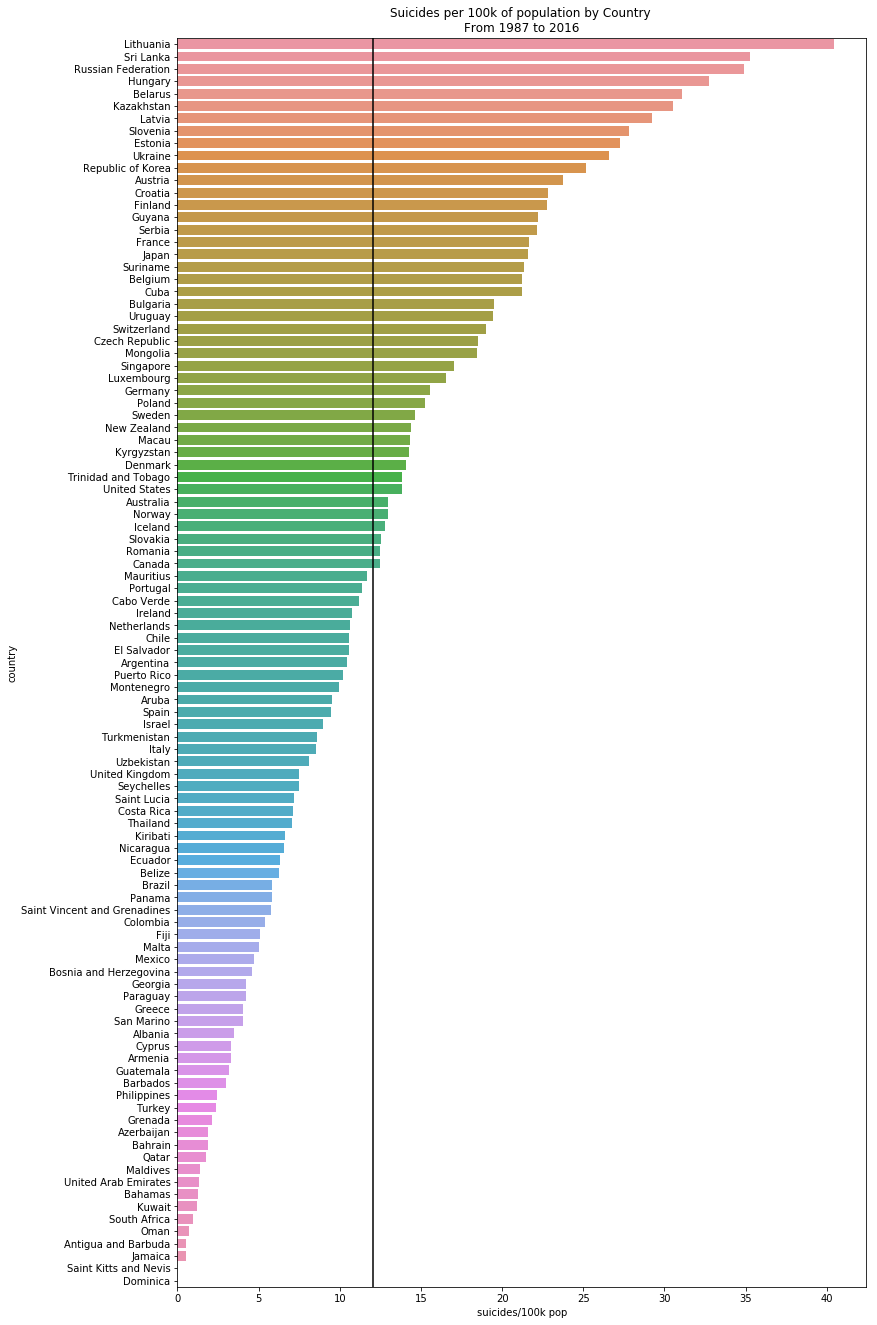

In [7]:
by_country_suicide= df.groupby('country').mean().sort_values('suicides/100k pop', ascending=False).reset_index()


plt.figure(figsize=(22,36))
plt.subplot(221)
sns.barplot(x='suicides/100k pop',y='country',data=by_country_suicide)
plt.axvline(x=by_country_suicide['suicides/100k pop'].mean(), color='k')
plt.gca().xaxis.tick_bottom()
plt.title('Suicides per 100k of population by Country \nFrom 1987 to 2016')

plt.tight_layout()

* Mean Suicides/100k population = 12.8
* For the exception of Sri Lanka, first 10 country are mostly from Easter European regions 

# 2.2 Evolution of Suicide and GDP 

Questions: 
1. How does evolution of suicide and gdp per capita look like ?
2. Can trend be established ?
3. Is there a correlation between Suicide/100k of population and GDP per capita ?
4. Is there any anomalies present ?

Method:**
1. Remove outliers from Suicide/100k and GDP_per_capita
2. Visually inspect plot both Suicide/100k and GDP_per_capita as a function of years 
3. Look at Pearson Correlation Coefficint between the two features


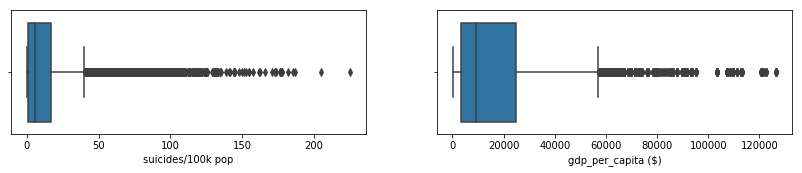

In [8]:
plt.figure(figsize=(14,5))
plt.subplot(221)
sns.boxplot(df['suicides/100k pop'])

plt.subplot(222)
sns.boxplot(df['gdp_per_capita ($)'])

* Suicides/100k population data is more skewed by outliers than gdp_per_capita 
* Lets apply IQR method to remove outliers from both features 

In [9]:
def subset_by_iqr(df, column, whisker_width=1.5):

    # Calculate Q1, Q2 and IQR
    q1 = df[column].quantile(0.25)                 
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    # Apply filter with respect to IQR, including optional whiskers
    
    filter = (df[column] >= q1 - whisker_width*iqr) & (df[column] <= q3 + whisker_width*iqr)
    return df.loc[filter]                                                     


df_filtered_suicide = subset_by_iqr(df, 'suicides/100k pop', whisker_width=1.5)
df_filtered_gpd = subset_by_iqr(df, 'gdp_per_capita ($)', whisker_width=1.5)

df_filtered_suicide = df_filtered_suicide.rename(columns ={'suicides/100k pop' : 'filtered_suicides/100k pop'})
df_filtered_gpd = df_filtered_gpd.rename(columns ={'gdp_per_capita ($)' : 'filtered_gdp_per_capita ($)'})


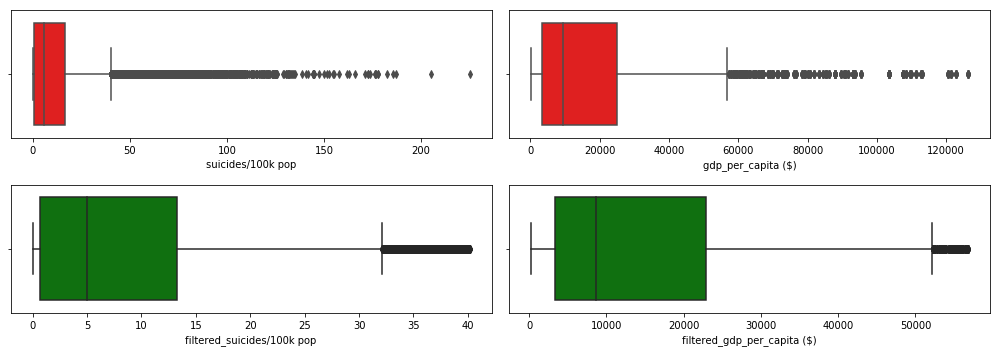

In [10]:
plt.figure(figsize=(14,5))
plt.subplot(221)
sns.boxplot(df['suicides/100k pop'], color = 'red')
plt.gca().xaxis.tick_bottom()

plt.subplot(222)
sns.boxplot(df['gdp_per_capita ($)'],  color = 'red')
plt.gca().xaxis.tick_bottom()

plt.subplot(223)
sns.boxplot(df_filtered_suicide['filtered_suicides/100k pop'],color = 'g')
plt.gca().xaxis.tick_bottom()

plt.subplot(224)
sns.boxplot(df_filtered_gpd['filtered_gdp_per_capita ($)'], color = 'g')
plt.gca().xaxis.tick_bottom()


plt.tight_layout()

* Data looks much less skewed after IQR method was applied
* In order to look for a trend and correaltion, lets merge two filtered data frames 

In [11]:
df_filtered = df_filtered_suicide.merge(df_filtered_gpd)

print ('Original data: ',df.shape[0])
print ('Filtered data: ',df_filtered.shape[0])

print ('Percent outliers by suicides/100k pop and GDP: ', 100 - df_filtered.shape[0]*100/df.shape[0])



Original data:  27820
Filtered data:  24785
Percent outliers by suicides/100k pop and GDP:  10.909417685118626


Approximately 11 % of data has been removed due to outliers in suicides/100k population and gdp_per_capita features 

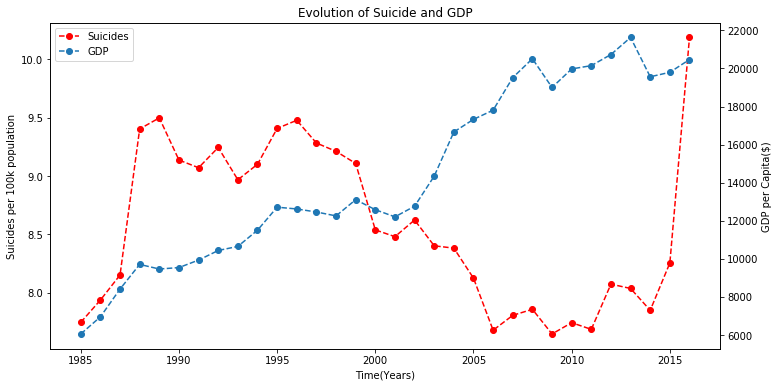

,year,suicides/100k pop,gdp_per_capita ($)
year,1.000000,-0.366763,0.967455
suicides/100k pop,-0.366763,1.000000,-0.403811
gdp_per_capita ($),0.967455,-0.403811,1.000000


In [12]:

# Plotting Suicides/100k of population and GDP_per_capita as a function of years

suicide_year_gdp = df_filtered[['suicides/100k pop','year','gdp_per_capita ($)']].groupby(['year']).mean().reset_index()

fig, ax1 = plt.subplots(figsize=(12,6))

# Plot the suicides over the years.
ln1 = ax1.plot(suicide_year_gdp['year'], suicide_year_gdp['suicides/100k pop'], 'ro--', label='Suicides')
plt.gca().xaxis.tick_bottom()
# Adding GDP plot to the same plot, but on different scale.
ax2 = ax1.twinx()
ln2 = ax2.plot(suicide_year_gdp['year'], suicide_year_gdp['gdp_per_capita ($)'], 'o--', label='GDP')

# Joining legends.
lns = ln1 + ln2
labels = [l.get_label() for l in lns]
ax1.legend(lns, labels, loc=2)

# Setting labels
ax1.set_ylabel('Suicides per 100k population')
ax2.set_ylabel('GDP per Capita($)')
ax1.set_xlabel('Time(Years)')
plt.title ('Evolution of Suicide and GDP')

plt.show()

suicide_year_gdp.corr()

* Correlation between GDP_per_capita and Suicide/100k of population is **-0.40**. This susggests poor relationship between rich countries and suicide rate 
* Stronger correlation is observed between GDP_per_capita and Time. This suggests that globally speaking humans become richer
* Anomaly: Interesting spike in suicide is observed in 2016. Lets look at countries that can possible cause it.

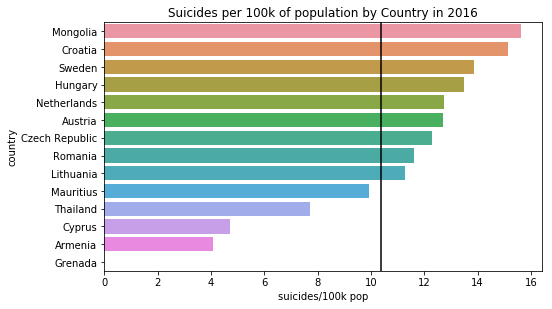

In [13]:
df_filtered_2015_2016 = df_filtered[df_filtered['year']==2016]


by_country_suicide= df_filtered_2015_2016.groupby('country').mean().sort_values('suicides/100k pop', ascending=False).reset_index()


plt.figure(figsize=(14,8))
plt.subplot(221)
sns.barplot(x='suicides/100k pop',y='country',data=by_country_suicide)
plt.axvline(x=by_country_suicide['suicides/100k pop'].mean(), color='k')
plt.gca().xaxis.tick_bottom()
plt.title('Suicides per 100k of population by Country in 2016')

plt.tight_layout()

* It looks like only 14 out of 101 countries are present(recorded) in 2016 in filtered data set, hence the spike in suicide rate can be ignored

# 2.3 Suicide comparison between Sex, Age, and Generation groups

Questions: 
1. What sex group has the highest suicide rate?
2. What age group has the highest suicide rate?
3. Is there a correlation between Suicide/100k of population and GDP per capita ?
4. Is there any anomalies present ?

Method:**
1. Visually inspect plot both Suicide/100k and GDP_per_capita as a function of years 




In [14]:
by_Sex = df.groupby(['sex']).mean().sort_values('suicides/100k pop', ascending=True).reset_index()
by_Sex_Time = df.groupby(['sex','year']).mean().sort_values('suicides/100k pop', ascending=True).reset_index()
by_Sex_Age = df.groupby(['sex','age']).mean().sort_values('suicides/100k pop', ascending=True).reset_index()
by_Sex_Gen = df.groupby(['sex','generation']).mean().sort_values('suicides/100k pop', ascending=True).reset_index()


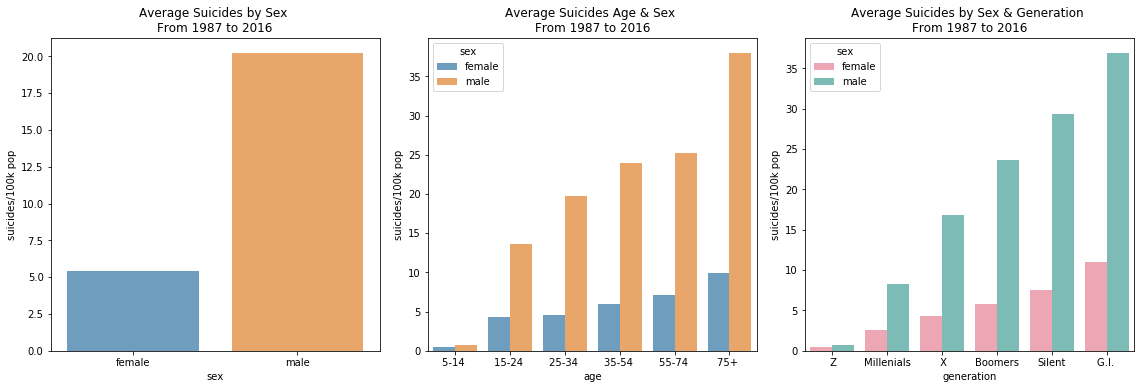

In [15]:
plt.figure(figsize=(16,10))

plt.subplot(231)
sns.barplot(x='sex',y='suicides/100k pop', data=by_Sex,alpha=0.7,  ci='sd')
plt.gca().xaxis.tick_bottom()
plt.title('Average Suicides by Sex \nFrom 1987 to 2016')

plt.subplot(232)
sns.barplot(x='age',y='suicides/100k pop', hue='sex', data=by_Sex_Age,alpha=0.7)
plt.gca().xaxis.tick_bottom()
plt.title('Average Suicides Age & Sex \nFrom 1987 to 2016')

plt.subplot(233)
sns.barplot(x='generation',y='suicides/100k pop', hue='sex', data=by_Sex_Gen, alpha=0.7, palette=('husl'))
plt.gca().xaxis.tick_bottom()
plt.title('Average Suicides by Sex & Generation \nFrom 1987 to 2016')

plt.tight_layout()

* Number of suicides comminted by males is 3.5 time higher than females
* Generally speaking, the older people get the more likely they commit suicide
* The riskiest age group is 75+ years old
* Women of 15-24 and 25-34 age groups have a very similar suicide numbers
* Z generation has the lowest suicide rate due to low amount of data recorded
* **Anomaly:** G.I. Generation showed the highest averaged suicide/100k of population, however the amount of data recorded for G.I. generation is lowest. This might explain why mean value is high. 

# 2.4 Evolution of suicide rate by Sex, Age, and Generation 
Questions: 
1. How does the evolution of suicide look like for men and women? Any spikes in the time series ?
2. How does the evolution of suicide look like for age groups and generations  ? Any similarities between time series ?
3. What the overal suicide evolution trends ?
4. Is there any anomalies present ?

Method:**
1. Visually inspect plot both Suicide/100k and GDP_per_capita as a function of years 

In [16]:
by_Gen_Time = df.groupby(['generation','year']).mean().sort_values('suicides/100k pop', ascending=True).reset_index()
by_Age_Time = df.groupby(['age','year']).mean().sort_values('suicides/100k pop', ascending=True).reset_index()

Text(0.5, 1.0, 'Evolution of average sucide/100k of population by Generation')

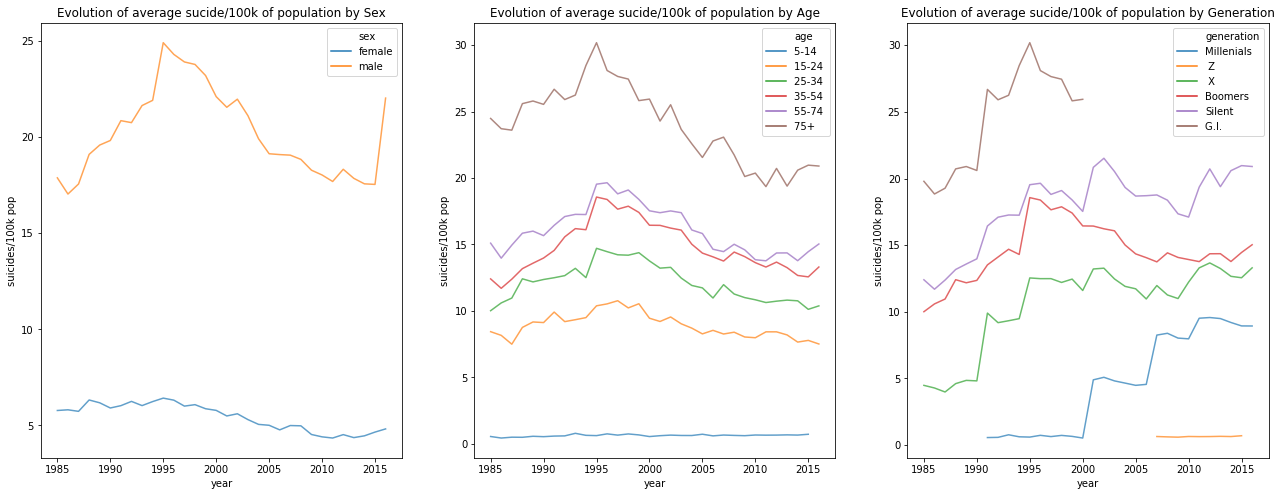

In [17]:
plt.figure(figsize=(22,8))
fig.subplots_adjust(hspace=.5)


plt.subplot(131)
sns.lineplot(x='year',y='suicides/100k pop', hue='sex', data=by_Sex_Time,alpha=0.7)
plt.gca().xaxis.tick_bottom()
plt.title('Evolution of average sucide/100k of population by Sex')

plt.subplot(132)
sns.lineplot(x='year',y='suicides/100k pop', hue='age', data=by_Age_Time, alpha=0.7)
plt.gca().xaxis.tick_bottom()
plt.title('Evolution of average sucide/100k of population by Age')

plt.subplot(133)
sns.lineplot(x='year',y='suicides/100k pop', hue='generation', data=by_Gen_Time, alpha=0.7)
plt.gca().xaxis.tick_bottom()
plt.title('Evolution of average sucide/100k of population by Generation')



* Interesting spiked in males suicide occured between 1994-1996. This observation might require additional investigation
* Age groups of 5-14 and 75+ years old are have the lowest and highest suicide rates accordingly. 3 
* Recall from Data Cleaning 1.3 section that the amount of data is not the same across Generations. This is why suicide time series of Generation G.I. ends at the year of 2000. Similar behavior is observed with Generation Z which data starts to be recorded in 2006. 
* This is possibly due to the fact that Generation G.I. is the oldest of all generations and most of the suicides occured at 75+ years. Meanwhile Generation Z is the youngest generation and number of suicides has not been peaked yet.
* Overall world's suicide rate is falling 

# Suicide Rates EDA Conclusions:
1. Men commit 3.5 times more suicides than women
2. Overall number of suicides is declining as time progresses
3. Correlation of -0.4 between GDP_per_capita and suicide/100k has been established
4. Number of suisides increases with aging

# 3.0 Case Study: Do warmer countries have lower suicide rate ?

* **Approach: **Compare mean suicide_rate_per_100k between two samples of 10-20 countries with different climates

** Assumptions:**
1. European and North American countries are primerely COLD 
2. Asian, South American, African countries are primeraly WARM


**Method:**
1. Group countries by continent
2. Randomly select 10-20 countries for Europe and Latin America / SouthEast Asia
3. Conduct t-Test to identify mean difference between groups


**NOTE:**
1. To avoid Confirmation Bias, I decided not to plot Suicide Rate by Continent
2. To find out more about Welch's t-Test follow the [Wikipedia link](https://en.wikipedia.org/wiki/Welch%27s_t-test)


# 3.1 Data Preparation 

In [64]:
# Load world-capitals-gps
continents=pd.read_csv("../input/world-capitals-gps/concap.csv")   # world GPS
suicide = df

In [65]:
continents['country'] = continents['CountryName'].apply(lambda x: x.lower())
suicide['country'] = suicide['country'].apply(lambda x: x.lower())

suicide_country = suicide.groupby(['country']).mean().reset_index()

# Merging Suicidce and GPS dataframes based on country using left join method
combined_df = pd.merge(suicide_country,
                            continents[['country','ContinentName']]
                            ,on='country',how='left')

combined_df[combined_df.isna().any(axis=1)]

suicide_country shape: 
left_join_results shape: 
There are 0 missing continents in the left_join_results. 


,country,year,suicides_no,population,suicides/100k pop,gdp_per_capita ($),ContinentName
17,cabo verde,2011.00,3.500000,3.768158e+04,11.153333,4124.000000,NaN
73,republic of korea,2000.00,703.575269,3.642325e+06,25.135618,14801.258065,NaN
75,russian federation,2002.00,3733.771605,1.139137e+07,34.892377,6518.814815,NaN
78,saint vincent and grenadines,2002.12,0.413333,8.125540e+03,5.755433,4954.640000,NaN


Since there are only four contries that dont have continent name, lets do manual imputation

In [66]:
# Lets impute countries have not been assigned with a continent name
combined_df.reset_index()

combined_df.loc[17,'ContinentName'] = 'Africa'
combined_df.loc[73,'ContinentName'] = 'Asia'
combined_df.loc[75,'ContinentName'] = 'Europe'
combined_df.loc[78,'ContinentName'] = 'North America'

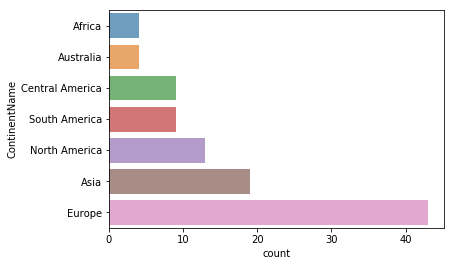

In [67]:
# Lets look have many countries are in each continent group
sns.countplot(y='ContinentName',data =combined_df, alpha=0.7, order=reversed(combined_df['ContinentName'].value_counts().index))


In [68]:
asian_countries =         combined_df.loc[combined_df['ContinentName']=='Asia']
european_countries =      combined_df.loc[combined_df['ContinentName']=='Europe']
south_america_countries = combined_df.loc[combined_df['ContinentName']=='South America']
north_america_countries = combined_df.loc[combined_df['ContinentName']=='North America']
africa_countries =        combined_df.loc[combined_df['ContinentName']=='Africa']

# 3.2 Experiment: Suicide rate t-Test comparison between two samples from different continent 


Ho : Warm and Cold countries are **NOT different** in their average suicide rate

Ha : Warm and Cold countries are different in their average suicide rate 

Ho gets rejected if **p < 0.05**

# Looping T-test

**Method:**

1. Conduct ten t-tests based on country random permutations within each continent groups 

1. Identify % of test in favor of accepting hypothesis 

In [137]:
# Looping 10 T-test

t_test_result=[]
def t_test_loop(group_1,group_2,sample_size):
    
    group1_continent = group_1['ContinentName'].iloc[0]
    group2_continent = group_2['ContinentName'].iloc[0]
    print ('%s vs %s (sample size=%s) :  \n'%(group1_continent,group2_continent,sample_size))
    for i in range(11):
        
        random_group1_countries = group_1.sample(sample_size)
        random_group2_countries = group_2.sample(sample_size)
        
        group1_suicide = random_group1_countries['suicides/100k pop'].tolist()
        group2_suicide = random_group2_countries['suicides/100k pop'].tolist()
    
        p_val = scipy.stats.ttest_ind(group1_suicide,group2_suicide,equal_var=False).pvalue
        t_test_result.append(round(p_val,2))
        print ('Welch t-Test results:',scipy.stats.ttest_ind(group1_suicide,group2_suicide,equal_var=False))
        
    
  
    return  print ('\nP-value results of series of t-Tests: ',t_test_result)
    
t_test_loop(north_america_countries,south_america_countries,9)

North America vs South America (sample size=9) :  

Welch t-Test results: Ttest_indResult(statistic=-2.4203941885585896, pvalue=0.0295656808004013)
Welch t-Test results: Ttest_indResult(statistic=-1.3838468438757896, pvalue=0.1854383370833403)
Welch t-Test results: Ttest_indResult(statistic=-1.2951949068223787, pvalue=0.2136336906867313)
Welch t-Test results: Ttest_indResult(statistic=-1.1797844440149499, pvalue=0.2553943816971266)
Welch t-Test results: Ttest_indResult(statistic=-2.041581514431903, pvalue=0.05807788202076258)
Welch t-Test results: Ttest_indResult(statistic=-1.895550832398439, pvalue=0.07624093684697505)
Welch t-Test results: Ttest_indResult(statistic=-1.6155016959830018, pvalue=0.12576436038693034)
Welch t-Test results: Ttest_indResult(statistic=-1.3162788411761162, pvalue=0.20662685789652405)
Welch t-Test results: Ttest_indResult(statistic=-1.5991231047906127, pvalue=0.12946159399195625)
Welch t-Test results: Ttest_indResult(statistic=-3.4802355849427498, pvalue=0.005

# Single t-Test with countries printed

In [110]:
def t_test(group_1,group_2,sample_size):
    
    group1_continent = group_1['ContinentName'].iloc[0]
    group2_continent = group_2['ContinentName'].iloc[0]
    
    random_group1_countries = group_1.sample(sample_size)
    random_group2_countries = group_2.sample(sample_size)
    
    group1_suicide = random_group1_countries['suicides/100k pop'].tolist()
    group2_suicide = random_group2_countries['suicides/100k pop'].tolist()

    p_val = scipy.stats.ttest_ind(group1_suicide,group2_suicide,equal_var=False).pvalue
    
    group_1_mean = round(random_group1_countries['suicides/100k pop'].mean(),2)
    group_1_std = round(random_group1_countries['suicides/100k pop'].std(),2)
    group_2_mean = round(random_group2_countries['suicides/100k pop'].mean(),2)
    group_2_std = round(random_group2_countries['suicides/100k pop'].std(),2)
    
    print ('%s vs %s (sample size=%s) :  \n'%(group1_continent,group2_continent,sample_size))
    
    print ('1st group countries:',random_group1_countries['country'].tolist())
    print ('2nd group countries:',random_group2_countries['country'].tolist())
    
    print ('\n1st group average suicide/100k of population:  %s +- %s '%(group_1_mean,group_1_std))
    print ('2st group average suicide/100k of population:  %s +- %s '%(group_2_mean,group_2_std))

    print ('\nWelch t-Test results:',scipy.stats.ttest_ind(group1_suicide,group2_suicide,equal_var=False))
    
    if p_val<0.05:
        print ('\np values = {} ==> reject Ho'.format(round(p_val,2)))
    else:
        print ('\np values = {} ==> can NOT reject Ho'.format(round(p_val,2)))
    
t_test(asian_countries,european_countries,10)

Asia vs Europe (sample size=10) :  

1st group countries: ['macau', 'kuwait', 'israel', 'singapore', 'philippines', 'united arab emirates', 'sri lanka', 'japan', 'kazakhstan', 'bahrain']
2nd group countries: ['iceland', 'lithuania', 'switzerland', 'san marino', 'greece', 'poland', 'belgium', 'italy', 'montenegro', 'malta']

1st group average suicide/100k of population:  13.45 +- 12.57 
2st group average suicide/100k of population:  14.04 +- 11.07 

Welch t-Test results: Ttest_indResult(statistic=-0.11120134458845732, pvalue=0.9127067237984587)

p values = 0.91 ==> can NOT reject Ho


# 3.3 Conclusions: Do warmer countries have lower suicide rate ?

Conclusions are based on 90% of similar t-test results 

Null hypothesis **can NOT be rejected** for the following samples 
1. Asia vs Europe, sample = 10
2. Asia vs North America, sample = 10
2. South vs North America, sample = 9

Null hypothesis **CAN BE rejected** for the following samples 
1. North America vs Europe, sample = 10


Based on this analysis we found no evidence that climate alone has an effect on suicide rate. Obviously, a multivariate analysis is required to explain such phenomena, however couple take aways we get from the exercise is that wealth and climate alone can not be determinent factors for predicting suicide rate. 